Работа 5. Архитектуры НС и Transfer Learning

Задание 1. Использование предобученной модели

In [34]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from io import BytesIO
from PIL import Image
from urllib.request import urlopen

1.1 Выбор и импортирт предобученной модели СНС для решения задач классификации

In [35]:
model = keras.applications.MobileNet()

model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

1.2 Загрузка 5 изображений с разными классами из сети Интернет и их сохранение в список images

In [36]:
urls = ['http://t3.gstatic.com/licensed-image?q=tbn:ANd9GcRkYMBfwxmuKiGFlGVFIBS-WJG7rw5XMEzojPhtE72r_Y6qRlpbWzjPWPn98Xp-xoc8H3ZQWNgPU_x3191aHNw',
        'https://encrypted-tbn0.gstatic.com/licensed-image?q=tbn:ANd9GcREvwT1NNa8thkSZ3O4DlZU9zY-OB7wNpIHHV7CPicj4hcq9LcSdCmXsw457xjRwJg0b9h398heT-jIWPI',
        'https://upload.wikimedia.org/wikipedia/commons/thumb/8/87/Red-headed_rock_agama_%28Agama_agama%29_male.jpg/1024px-Red-headed_rock_agama_%28Agama_agama%29_male.jpg',
        'https://i.natgeofe.com/n/b96b572c-98e2-4ec2-a714-08a6b95cf646/triceratopshorridus_hexdcb_3x4.jpg',
        'https://encrypted-tbn3.gstatic.com/licensed-image?q=tbn:ANd9GcS0X-psAIhtT_dX3ne3WUAY_1PLYIDHMaw-HDUGVf-B58t8xMArAXQaYCu9DIfGBsDvYRx9rhbcI2QkFX0']
images = []
for url in urls:
   req = urlopen(url) # используя метод urlopen, получаем объект запроса по ссылке (изображение)
   image = np.asarray(bytearray(req.read()), dtype=np.uint8) # преобразуем потоковый набор данных в массив numpy
   image = cv2.imdecode(image, -1) # декодируем изображение в привычный для отображения формат
   images.append(image)

1.3 Создание функции, возвращающей список с преобразованными изображениями под формат входных данных выбранной модели СНС

In [37]:
def processImages(images):
  image_list = []
  for img in images:
        image = cv2.resize(img , (224, 224, ))
        image = image.astype("float") / 255.0
        image = image.reshape( 224, 224, 3)
        image_list.append(image)

  return image_list

1.4 Проверка формы преобразованных данных

In [38]:
print(np.shape(processImages(images)))
for i in processImages(images):
  print(np.shape(i))

(5, 224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


1.5 Создание функции, принимающей на вход список с представлениями обработаннах изображений и возвращающей список предсказанных нейросетью классов.

In [39]:
def predicted_list(model, images):
  for img in images:
      reshaped = img.reshape(-1, 224, 224, 3)
      preds = model.predict(reshaped)
      text = keras.applications.mobilenet.decode_predictions(preds, top=3)
      print(text)
      cv2.putText(img*255, str(text), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0, 0, 255), 2)
      cv2_imshow(img*255)

1.6 Вывод изображений и соответствующих им классов

1/1 [==============================] - 0s 399ms/step
[[('n01582220', 'magpie', 0.9394325), ('n01592084', 'chickadee', 0.033818424), ('n01824575', 'coucal', 0.009373205)]]


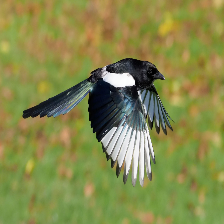

1/1 [==============================] - 0s 19ms/step
[[('n01641577', 'bullfrog', 0.646728), ('n01644900', 'tailed_frog', 0.34906662), ('n01644373', 'tree_frog', 0.0017738522)]]


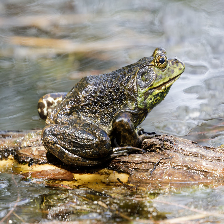

1/1 [==============================] - 0s 19ms/step
[[('n01687978', 'agama', 0.987978), ('n01682714', 'American_chameleon', 0.0042621014), ('n01685808', 'whiptail', 0.003069344)]]


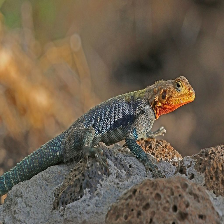

1/1 [==============================] - 0s 20ms/step
[[('n01704323', 'triceratops', 0.99995637), ('n01694178', 'African_chameleon', 2.1040029e-05), ('n01695060', 'Komodo_dragon', 2.473641e-06)]]


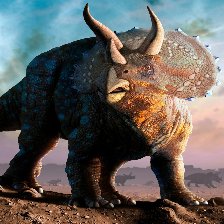

1/1 [==============================] - 0s 20ms/step
[[('n01820546', 'lorikeet', 0.98865414), ('n01537544', 'indigo_bunting', 0.008303045), ('n01818515', 'macaw', 0.0011805234)]]


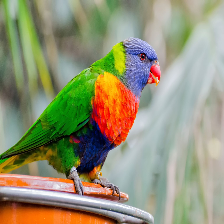

In [40]:
predicted_list(model, processImages(images))

Задание 2. Использование обученной модели для работы с собственным датасетом

In [102]:
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import random
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from io import BytesIO
from PIL import Image
from urllib.request import urlopen

DenseNet121_model = keras.applications.DenseNet121( 
    include_top=False, # убираем полносвязные слои
    input_shape=(64 ,64 ,3), # меняем параметры входных данных на свои
    pooling='avg', # после последнего сверточного слоя будет применена операция среднего пулинга
    weights='imagenet'
    )

2.1 Загрузка обработанных изображений с диска

In [103]:
data = []
labels = []

with open('/content/drive/MyDrive/DeepLearning/pickle/64x64_images.pickle','rb') as f:
  data = pickle.load(f)
with open('/content/drive/MyDrive/DeepLearning/pickle/64x64_labels.pickle','rb') as f:
  labels = pickle.load(f)

1.2 Разбивка на обучающую выборку и выборку валидации

In [104]:
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.1, random_state=42)

1.3 Нормализация данных

In [105]:
X_train = np.array(X_train)/255.0
X_test = np.array(X_test)/255.0

X_train = np.reshape(X_train, (2700, 64, 64, 3))
X_test = np.reshape(X_test, (300, 64, 64, 3))

1.4 Классификация данных

In [106]:
from keras.utils import to_categorical

classes = {'apple': 0, 'banana': 1, 'orange': 2}

y_train = np.array([classes[i] for i in Y_train])
y_test = np.array([classes[i] for i in Y_test])
Y_train = to_categorical(y_train, 3)
Y_test = to_categorical(y_test, 3)

In [107]:
print('Train: X = ', X_train.shape)
print('Test: X = ', X_test.shape)
print('Train: y = ', Y_train.shape)
print('Test: y = ', Y_test.shape)

Train: X =  (2700, 64, 64, 3)
Test: X =  (300, 64, 64, 3)
Train: y =  (2700, 3)
Test: y =  (300, 3)


1.5 Создание архитектуры нейронной сети

In [108]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow import keras

DenseNet121_model.trainable = False # замораживаем все слои базовой модели

model1 = keras.Sequential([
    DenseNet121_model,
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(3,  activation='softmax')
])

model1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense_21 (Dense)            (None, 8)                 8200      
                                                                 
 dense_22 (Dense)            (None, 4)                 36        
                                                                 
 dense_23 (Dense)            (None, 3)                 15        
                                                                 
Total params: 7,045,755
Trainable params: 8,251
Non-trainable params: 7,037,504
_________________________________________________________________


1.6 Компиляция модели

In [109]:
from keras.optimizers import SGD
opt = SGD(learning_rate=0.001)
model1.compile(optimizer=opt,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

1.7 Обучение нейронной сети

In [110]:
his = model1.fit(X_train, Y_train, batch_size=64, epochs=50, validation_split=0.2, verbose=False)

1.8 Оценка критерия качества работы нейронной сети представлением на графике

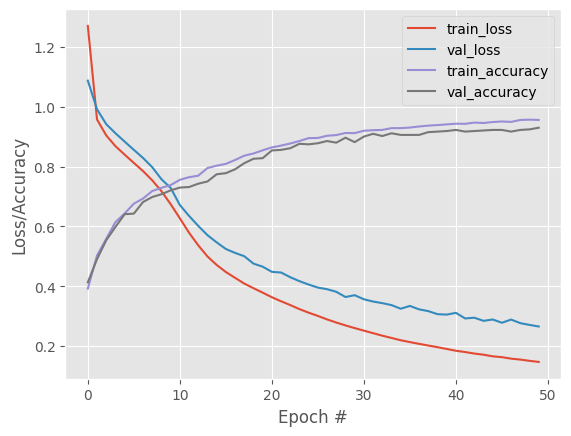

In [111]:
  plt.style.use("ggplot")
  plt.figure()
  plt.plot( his.history["loss"], label="train_loss")
  plt.plot( his.history["val_loss"], label="val_loss")
  plt.plot( his.history["accuracy"], label="train_accuracy")
  plt.plot( his.history["val_accuracy"], label="val_accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()

1.9 Сохранение обученной модели

In [112]:
model1.save("/content/drive/MyDrive/DeepLearning/work5/densenet121.h5", save_format="h5")

1.10 Подготовка тестовой выборки

In [113]:
class_names = ["apple", "banana", "orange"] 
val_images = sorted(list(paths.list_images("/content/drive/MyDrive/DeepLearning/Dataset/val/")))

1.11 Получение предсказаний нейронной сети на тестовой выборке

1/1 [==============================] - 2s 2s/step


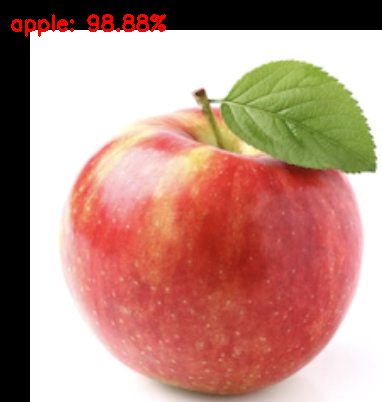

1/1 [==============================] - 0s 30ms/step


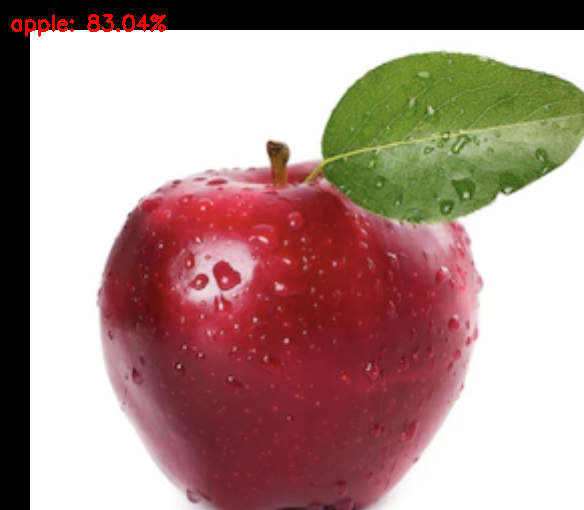

1/1 [==============================] - 0s 30ms/step


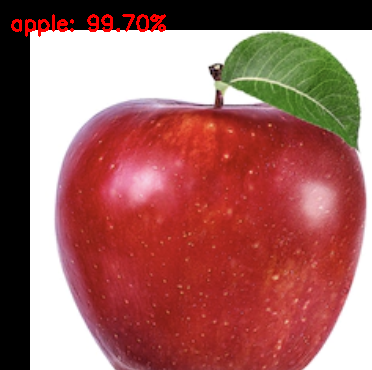

1/1 [==============================] - 0s 28ms/step


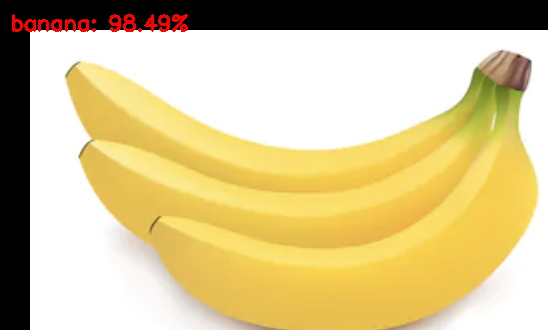

1/1 [==============================] - 0s 29ms/step


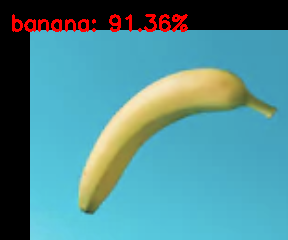

1/1 [==============================] - 0s 43ms/step


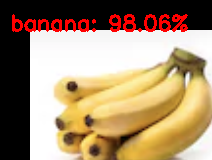

1/1 [==============================] - 0s 43ms/step


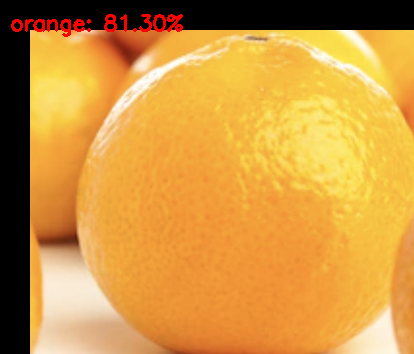

1/1 [==============================] - 0s 45ms/step


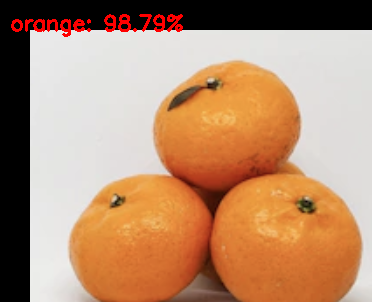

1/1 [==============================] - 0s 58ms/step


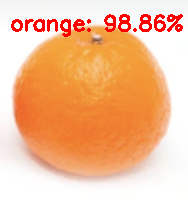

1/1 [==============================] - 0s 59ms/step


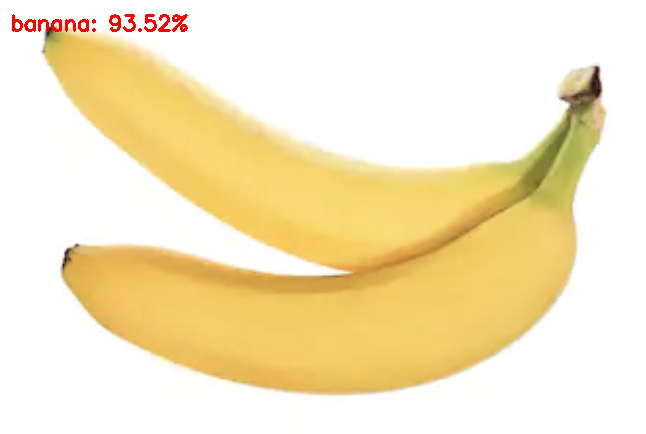

1/1 [==============================] - 0s 47ms/step


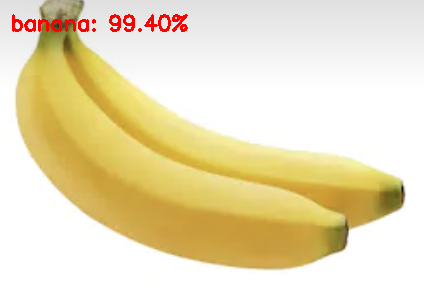

1/1 [==============================] - 0s 43ms/step


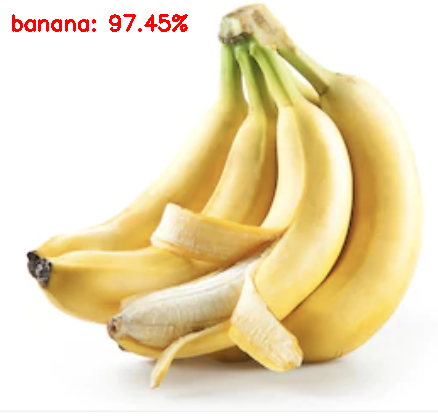

1/1 [==============================] - 0s 53ms/step


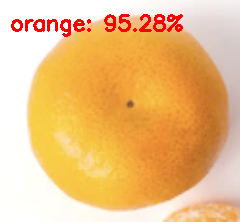

1/1 [==============================] - 0s 62ms/step


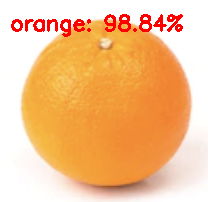

In [114]:
from keras import models

model2 = models.load_model("/content/drive/MyDrive/DeepLearning/work5/densenet121.h5")

for img in val_images:

  image = cv2.imread(img)
  output = image.copy()

  image = cv2.resize(image, (64, 64))
  image = image.flatten()

  # масштабируем значения пикселей к диапазону [0, 1]
  image = image.astype("float") / 255.0
  image = image.reshape(1, 64, 64, 3) 

  # делаем предсказание на изображении
  preds = model2.predict(image)  
  argmax = preds.argmax()

  # находим индекс метки класса с наибольшей вероятностью
  # соответствия
  i = preds.argmax(axis=1)[0]
  label = class_names[i]

  # Добавляем на исходное изображение метку класса и вероятность прогноза
  text = "{}: {:.2f}%".format(label, preds[0][i] * 100)
  cv2.putText(output, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0, 0, 255), 2)

  # показываем выходное изображение
  cv2_imshow(output)